# Volley (or racketball) simulation

Simulate max_games volley matches played by 'a' vs 'b' where 'a' as a probability 'prob' between 0 and 1 of winning a point. Games are played until a team wins 'sets_to_win' sets. A set is won when a team scores
more or equal 'points_to_win' points with a difference of at least 2 points from the other team score

In [1]:
%%capture cap --no-stderr
import random

a_win_prob = 0.52

max_games = 10000
sets_to_win = 2
points_to_win_standard = 21
points_to_win_last = 15

a_wins = b_wins = a_tot_points = b_tot_points = a_tot_sets = b_tot_sets = 0

print('F', 'P', 'AS', 'BS', 'AP', 'BP', 'AW', 'BW', 'ATS', 'BTS', 'ATP', 'BTP', 'WP', 'SP', 'PP', sep='\t') 

# Loop over all games in the simulation
while a_wins + b_wins < max_games:
    a_sets = b_sets = 0

    # Loop over all sets in a game
    while a_sets < sets_to_win and b_sets < sets_to_win:
        a_points = b_points = 0
        points_to_win = points_to_win_standard if a_sets + b_sets < 2 * sets_to_win - 1 else points_to_win_last
        
        # Loop over all points in a set
        while not (a_points >= points_to_win and a_points - b_points >= 2) and not (b_points >= points_to_win and b_points - a_points >= 2):
            flag = 1

            # Assign a point
            a_win_point = random.random() < a_win_prob
            if a_win_point:
                a_points += 1; a_tot_points += 1
            if not a_win_point:
                b_points += 1; b_tot_points += 1
            
            # Award a set
            if a_points >= points_to_win and a_points - b_points >= 2:
                a_sets += 1; a_tot_sets += 1; flag = 2
            if b_points >= points_to_win and b_points - a_points >= 2:
                b_sets += 1; b_tot_sets += 1; flag = 2

            # Award a game
            if a_sets == sets_to_win:
                a_wins += 1; flag = 3
            if b_sets == sets_to_win:
                b_wins += 1; flag = 3

            print(flag, int(a_win_point), a_sets, b_sets, a_points, b_points,  
                a_wins, b_wins, a_tot_sets, b_tot_sets, a_tot_points, b_tot_points,
                round(a_wins / (a_wins + b_wins) if a_wins + b_wins != 0 else 0, 3), 
                round(a_tot_sets / (a_tot_sets + b_tot_sets) if a_tot_sets + b_tot_sets != 0 else 0, 3), 
                round(a_tot_points / (a_tot_points + b_tot_points) if a_tot_points + b_tot_points != 0 else 0, 3), 
                sep='\t')

           WP     SP     PP
918067  0.661  0.609  0.521


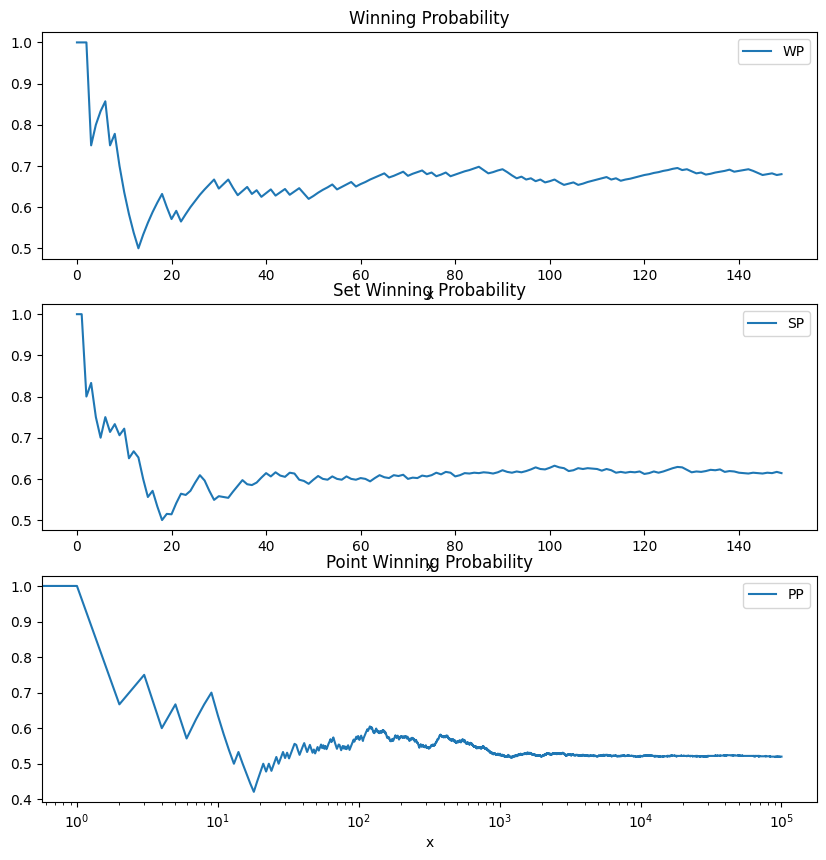

In [2]:
import pandas as pd
from io import StringIO

# Avoids SettingWithCopyWarning
pd.options.mode.copy_on_write = True

data_io = StringIO(cap.stdout)
df = pd.read_csv(data_io, sep='\t')

# Create a dataset containing just rows where Flag is 2
dfp = df[df['F'] == 1]
dfs = df[df['F'] == 2]
dfw = df[df['F'] == 3]

# Plot first N, N1 rows
N = 150
N1 = int(10e4)
dfw = dfw.head(N)
dfs = dfs.head(N)
dfp = dfp.head(N1)

# Create an increasing integer sequence for x-values
dfw['x'] = range(0, N)
dfs['x'] = range(0, N)
dfp['x']  = range(0, N1)

print(df[['WP', 'SP', 'PP']].tail(1))

# On the same plot, plot the winning probability, set winning probability, and point winning probability in time
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

dfw.plot(x='x', y='WP', ax=ax[0], title='Winning Probability');
dfs.plot(x='x', y='SP', ax=ax[1], title='Set Winning Probability');
ax[2].set_xscale('log')
dfp.plot(x='x', y='PP', ax=ax[2], title='Point Winning Probability');

In [18]:
import random
import pandas as pd

a_win_prob = 0.52

max_games = 100000
sets_to_win = 2
points_to_win_standard = 21
points_to_win_last = 15

a_wins = b_wins = a_tot_points = b_tot_points = a_tot_sets = b_tot_sets = 0

# Docs recommend not to add rows to a DataFrame in a loop, but to append them to a list and then create a DataFrame from the list
rows = []

# Loop over all games in the simulation
while a_wins + b_wins < max_games:
    a_sets = b_sets = 0

    # Loop over all sets in a game
    while a_sets < sets_to_win and b_sets < sets_to_win:
        a_points = b_points = 0
        points_to_win = points_to_win_standard if a_sets + b_sets < 2 * sets_to_win - 1 else points_to_win_last
        
        # Loop over all points in a set
        while not (a_points >= points_to_win and a_points - b_points >= 2) and not (b_points >= points_to_win and b_points - a_points >= 2):
            flag = 1

            # Assign a point
            a_win_point = random.random() < a_win_prob
            if a_win_point:
                a_points += 1; a_tot_points += 1
            if not a_win_point:
                b_points += 1; b_tot_points += 1
            
            # Award a set
            if a_points >= points_to_win and a_points - b_points >= 2:
                a_sets += 1; a_tot_sets += 1; flag = 2
            if b_points >= points_to_win and b_points - a_points >= 2:
                b_sets += 1; b_tot_sets += 1; flag = 2

            # Award a game
            if a_sets == sets_to_win:
                a_wins += 1; flag = 3
            if b_sets == sets_to_win:
                b_wins += 1; flag = 3

            rows.append({'F': flag, 'P': int(a_win_point), 'AS': a_sets, 'BS': b_sets, 'AP': a_points, 'BP': b_points,  'AW': a_wins, 'BW': b_wins, 'ATS': a_tot_sets, 'BTS': b_tot_sets, 'ATP': a_tot_points, 'BTP': b_tot_points})

            #rows.append([flag, int(a_win_point), a_sets, b_sets, a_points, b_points, a_wins, b_wins, a_tot_sets, b_tot_sets, a_tot_points, b_tot_points])

df = pd.DataFrame(rows, columns=['F', 'P', 'AS', 'BS', 'AP', 'BP', 'AW', 'BW', 'ATS', 'BTS','ATP', 'BTP'])

df['WP'] = df['AW'] / (df['AW'] + df['BW'])
df['SP'] = df['ATS'] / (df['ATS'] + df['BTS'])
df['PP'] = df['ATP'] / (df['ATP'] + df['BTP'])

             WP        SP        PP
9200989  0.6527  0.603539  0.519778


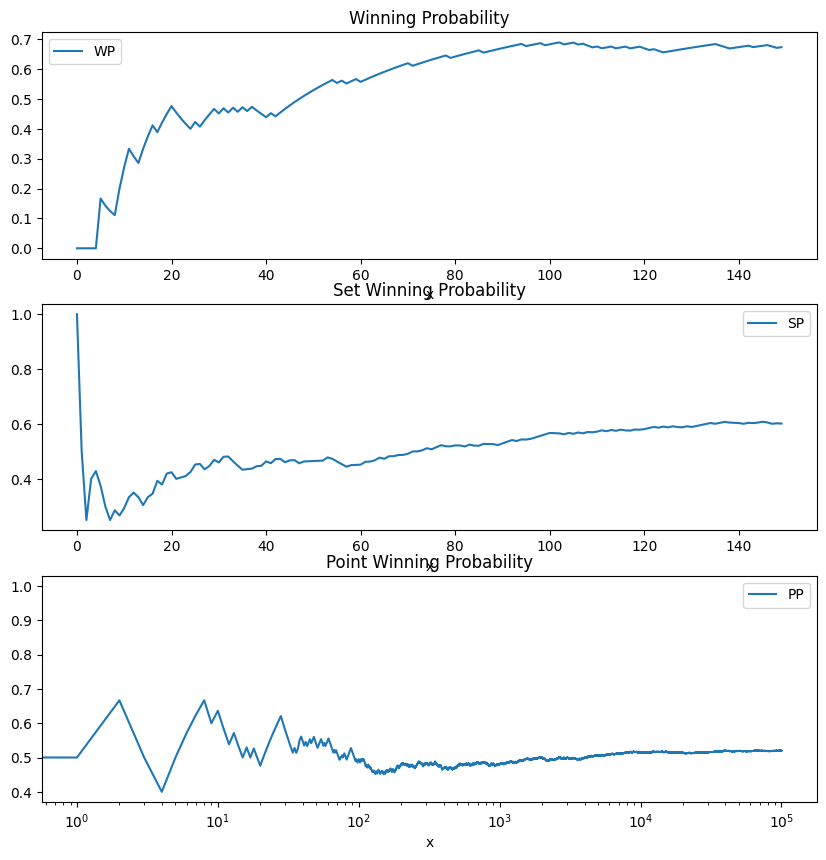

In [19]:
# Avoids SettingWithCopyWarning
pd.options.mode.copy_on_write = True

# Create a dataset containing just rows where Flag is 2
dfp = df[df['F'] == 1]
dfs = df[df['F'] == 2]
dfw = df[df['F'] == 3]

# Plot first N, N1 rows
N = 150
N1 = int(10e4)
dfw = dfw.head(N)
dfs = dfs.head(N)
dfp = dfp.head(N1)

# Create an increasing integer sequence for x-values
dfw['x'] = range(0, N)
dfs['x'] = range(0, N)
dfp['x']  = range(0, N1)

print(df[['WP', 'SP', 'PP']].tail(1))

# On the same plot, plot the winning probability, set winning probability, and point winning probability in time
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

dfw.plot(x='x', y='WP', ax=ax[0], title='Winning Probability');
dfs.plot(x='x', y='SP', ax=ax[1], title='Set Winning Probability');
ax[2].set_xscale('log')
dfp.plot(x='x', y='PP', ax=ax[2], title='Point Winning Probability');